# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from bs4 import BeautifulSoup
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable

SyntaxError: invalid syntax (<ipython-input-1-b6e3e85e4c11>, line 42)

## As we need different data points for different implementations of KNN.
#### 1. For Brute Force method I have tried taking varity of data points ranging from 100k to 40k, system was freezing at some point or other till I used only 30k points.

#### 2. For KD-Tree method I'm using 20k data points.


In [64]:
# using SQLite Table to read data 
# con_b is for brute force data

con_b = sqlite3.connect('database.sqlite') 

# I used 30k points while running brute force first and then
# reduced the number of data points to 20k for kd tree implementation

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con_b) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

# changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [65]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con_b)

In [66]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [67]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [68]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [69]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con_b)
display.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [70]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [71]:
# Deduplication of entries
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [72]:
# Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [73]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con_b)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [74]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [75]:
# Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
It's Branston pickle, what is there to say. If you've never tried it you most likely wont like it. If you grew up in the UK its a staple on cheese of cold meat sandwiches. It's on my lunch sandwich today! :)
First Impression: The friendly folks over at "Exclusively Dog" heard about my website and sent me 5 of their products to test.<br />Let me just start off by saying that I Love how sweet all of these treats taste. Dad was/is considering trying one because they look and smell so much like human cookies. Plus the ingredients are very straight forward, they are probably healthier than most the stuff Mom eats... But there in lies the problem. Dad thinks that they are too sweet for a puppy of any age. The second ingredient in almost all of them is sugar. As we all know puppies have a hard time processing sugar, and just like humans can dev

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [14]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
When I ordered these, I thought they were a bit pricey, but I decided to give them a try anyway.  I'm glad I did!  My dogs absolutely love these dried liver treats.  And, since my dogs are all small, I can cut the treats in half and still have large enough pieces to satisfy them. They're great for training; I'll definitely order them again, and would recommend them to anyone.
This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I've canceled my subscribe and save order and am now using Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3).
TOTALLY ORGASMIC.  these chips are the best spicy chip i have ever tasted.  signed up for the subscribe and save option.  the case contained 15(FIFTEEN, FULL SIZED BAGS) 

In [76]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I have canceled my subscribe and save order and am now using <a href="http://www.amazon.com/gp/product/B001ELL3U0">Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3)</a>.


In [22]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br  /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [23]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [77]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [78]:
# Combining all the above stundents 

preprocessed_reviews_b = []       # preprocessed reviews for brute force implementation
# tqdm is for printing the status bar

for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_b.append(sentance.strip())

100%|███████████████████████████████████████| 19354/19354 [00:07<00:00, 2495.83it/s]


In [79]:
len(preprocessed_reviews_b)

19354

In [80]:
len(final["Score"])

19354

# [4] Splitting the data 

Here before doing any vectorization we'll first split the data i.e (X,Y) in train data,
cross validation data and test data.

In [52]:
#final['Score'].value_counts().plot(kind='bar')

In [81]:
X = preprocessed_reviews_b
Y = final['Score'].values

In [82]:
print(X[0])

used victor fly bait seasons ca not beat great product


Now we are splitting the data in three parts
1. Train data             
2. Cross validation data
3. Test data                

In [83]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30) # this is random splitting
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.30) # this is random splitting


In [85]:
print(len(x_train))
print(len(x_cv))
print(len(x_test))

9482
4065
5807


# [5] Featurization

## [5.1] BAG OF WORDS

In [86]:
# BoW using scikit-learn

count_vect = CountVectorizer(min_df=10, max_features=10000)     # count_vect_b for brute force data
count_vect.fit(x_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
x_train_bow = count_vect.transform(x_train)
x_cv_bow = count_vect.transform(x_cv)
x_test_bow = count_vect.transform(x_test)

print("After vectorizations")
print(x_train_bow.shape, y_train.shape)
print(x_cv_bow.shape, y_cv.shape)
print(x_test_bow.shape, y_test.shape)
print("="*50)

print("the type of count vectorizer ",type(x_train_bow))
print("the type of count vectorizer ",type(x_cv_bow))
print("the type of count vectorizer ",type(x_test_bow))

some feature names  ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'acceptable', 'accepted', 'accident', 'according', 'account']
After vectorizations
(9482, 3442) (9482,)
(4065, 3442) (4065,)
(5807, 3442) (5807,)
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


## [5.2] TF-IDF

In [87]:
# TF-IDF for brute force

tf_idf_vect = TfidfVectorizer( min_df=10, max_features=10000)                #in scikit-learn
tf_idf_vect.fit(x_train)
print("some sample features",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

# we use the fitted TfidfVectorizer to convert the text to vector

x_train_tf = tf_idf_vect.transform(x_train)
x_cv_tf    = tf_idf_vect.transform(x_cv)
x_test_tf  = tf_idf_vect.transform(x_test)

print("After vectorizations")
print(x_train_tf.shape, y_train.shape)
print(x_cv_tf.shape, y_cv.shape)
print(x_test_tf.shape, y_test.shape)
print("="*50)

print("the type of tf-idf vectorizer ",type(x_train_tf))

some sample features ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'acceptable', 'accepted', 'accident', 'according', 'account']
After vectorizations
(9482, 3442) (9482,)
(4065, 3442) (4065,)
(5807, 3442) (5807,)
the type of tf-idf vectorizer  <class 'scipy.sparse.csr.csr_matrix'>


## [5.3] Word2Vec

In [88]:
# Train your own Word2Vec model using your own text corpus

list_of_sentance_train =[]

for sentance in x_train :
    list_of_sentance_train.append(sentance.split())

## Training w2v model

In [89]:
# this line of code trains your w2v model on the given list of sentances

w2v_model = Word2Vec(list_of_sentance_train, min_count = 5, size = 50, workers = -1)

In [90]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  5758
sample words  ['haribo', 'gummi', 'strawberries', 'tastiest', 'candy', 'available', 'may', 'biased', 'loved', 'candies', 'especially', 'pretty', 'much', 'entire', 'life', 'something', 'perfect', 'combination', 'texture', 'bite', 'make', 'chewy', 'fruit', 'flavored', 'happy', 'activity', 'one', 'favorite', 'fruits', 'naturally', 'found', 'many', 'years', 'ago', 'made', 'strawberry', 'bonus', 'even', 'looked', 'like', 'trying', 'obviously', 'not', 'taste', 'actual', 'sort', 'good', 'better', 'imitation', 'flavor']


# Converting Reviews into Numerical Vectors using W2V vectors

## Algorithm: Avg W2V

Converting Training data text

In [91]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list

for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)

100%|██████████████████████████████████████████| 9482/9482 [00:10<00:00, 912.22it/s]


(9482, 50)


Converting Cross validation data text

In [92]:
list_of_sentance_cv = []

for sentance in x_cv:
    list_of_sentance_cv.append(sentance.split())

In [93]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list

for sent in tqdm(list_of_sentance_cv):  # for each review/sentence
    sent_vec = np.zeros(50)               # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0;                         # num of words with a valid vector in the sentence/review
    for word in sent:                     # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)

100%|██████████████████████████████████████████| 4065/4065 [00:04<00:00, 847.81it/s]


(4065, 50)


Converting Test data text

In [94]:
list_of_sentance_test = []

for sentance in x_test :
    list_of_sentance_test.append(sentance.split())

In [95]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list

for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)

100%|██████████████████████████████████████████| 5807/5807 [00:06<00:00, 870.01it/s]


## Algorithm: TFIDF Weighted W2V

Converting Training data

In [96]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))

In [97]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████| 9482/9482 [01:26<00:00, 117.87it/s]


In [98]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████| 4065/4065 [00:37<00:00, 108.16it/s]


In [99]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████| 5807/5807 [00:52<00:00, 110.19it/s]


# [6] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [6.1] Applying KNN brute force

### [6.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

#### Starting with Hyperparameter tuning using simple for loop

Finding optimal K using Grid Search hyper parameter tuning

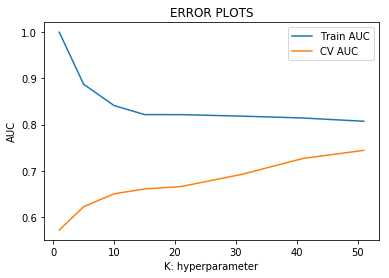

In [38]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

K = [1, 5, 10, 15, 21, 31, 41, 51]
knn = KNeighborsClassifier(algorithm= 'brute', n_jobs= -1)
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
grid = GridSearchCV(knn, parameters, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(x_train_bow, y_train)

train_auc_bow      = grid.cv_results_['mean_train_score']
cv_auc_bow         = grid.cv_results_['mean_test_score'] 

plt.plot(K, train_auc_bow, label='Train AUC')
plt.plot(K, cv_auc_bow, label='CV AUC')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [39]:
grid.best_estimator_

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=51, p=2,
           weights='uniform')

In [40]:
best_k_bow = 51

#### Testing with Test data

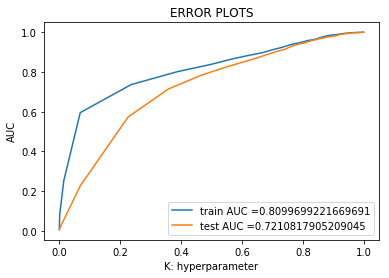

Train confusion matrix
[[  164  2000]
 [   98 11493]]
Test confusion matrix
[[  96 1211]
 [  74 7041]]


In [41]:
knn = KNeighborsClassifier(n_neighbors = best_k_bow, algorithm= 'brute')
knn.fit(x_train_bow, y_train)

train_fpr_bow, train_tpr_bow, thresholds_bow = roc_curve(y_train, knn.predict_proba(x_train_bow)[:,1])
test_fpr_bow, test_tpr_bow, thresholds_bow = roc_curve(y_test, knn.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*50)

print("Train confusion matrix")
print(confusion_matrix(y_train, knn.predict(x_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, knn.predict(x_test_bow)))

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

Starting with hyperparameter tuning.

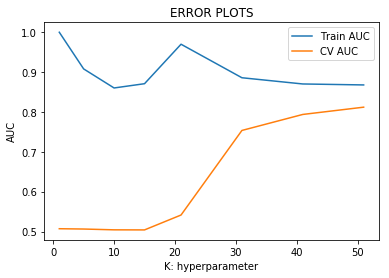

In [43]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

knn = KNeighborsClassifier(algorithm= 'brute', n_jobs= -1)
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
grid = GridSearchCV(knn, parameters, cv=3, scoring='roc_auc', n_jobs = -1)
grid.fit(x_train_tf, y_train)

train_auc_tf = grid.cv_results_['mean_train_score']
cv_auc_tf    = grid.cv_results_['mean_test_score'] 


plt.plot(K, train_auc_tf, label='Train AUC')

plt.plot(K, cv_auc_tf, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [44]:
grid.best_estimator_

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=51, p=2,
           weights='uniform')

In [45]:
best_k_tf = 51

Testing with Test data

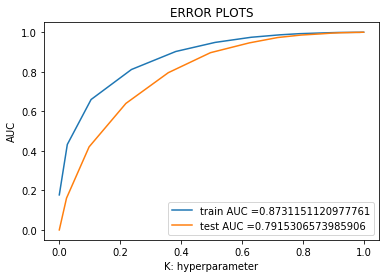

Train confusion matrix
[[    0  2164]
 [    0 11591]]
Test confusion matrix
[[   0 1307]
 [   0 7115]]


In [55]:
neigh = KNeighborsClassifier(n_neighbors = best_k_tf, algorithm= 'brute', n_jobs= -1)
neigh.fit(x_train_tf, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_b_tfidf, train_tpr_b_tfidf, thresholds_b_tfidf = roc_curve(y_train, neigh.predict_proba(x_train_tf)[:,1])
test_fpr_b_tfidf, test_tpr_b_tfidf, thresholds_b_tfidf = roc_curve(y_test, neigh.predict_proba(x_test_tf)[:,1])

plt.plot(train_fpr_b_tfidf, train_tpr_b_tfidf, label="train AUC ="+str(auc(train_fpr_b_tfidf, train_tpr_b_tfidf)))
plt.plot(test_fpr_b_tfidf, test_tpr_b_tfidf, label="test AUC ="+str(auc(test_fpr_b_tfidf, test_tpr_b_tfidf)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train_tf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test_tf)))

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

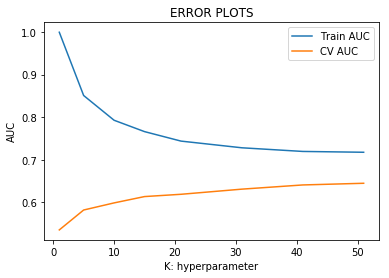

In [56]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier(algorithm= 'brute', n_jobs= -1)
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(sent_vectors_train, y_train)

train_auc_b_aw2v  = clf.cv_results_['mean_train_score']
cv_auc_b_aw2v     = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc_b_aw2v, label='Train AUC')
plt.plot(K, cv_auc_b_aw2v, label='CV AUC')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [57]:
grid.best_estimator_

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=51, p=2,
           weights='uniform')

In [58]:
best_k_b_aw2v = 51

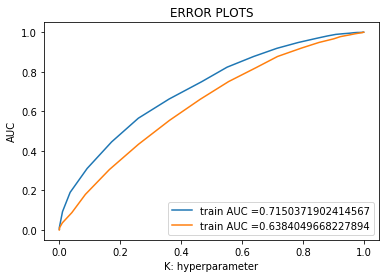

Train confusion matrix
[[    5  2159]
 [    2 11589]]
Test confusion matrix
[[   1 1306]
 [   0 7115]]


In [59]:
neigh = KNeighborsClassifier(n_neighbors = best_k_b_aw2v, algorithm='brute', n_jobs=-1)
neigh.fit(sent_vectors_train, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_b_aw2v, train_tpr_b_aw2v, thresholds_b_aw2v = roc_curve(y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr_b_aw2v, test_tpr_b_aw2v, thresholds_b_aw2v   = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_b_aw2v, train_tpr_b_aw2v, label="train AUC ="+str(auc(train_fpr_b_aw2v, train_tpr_b_aw2v)))
plt.plot(test_fpr_b_aw2v, test_tpr_b_aw2v, label="train AUC ="+str(auc(test_fpr_b_aw2v, test_tpr_b_aw2v)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [3]:
# Please write all the code with proper documentation

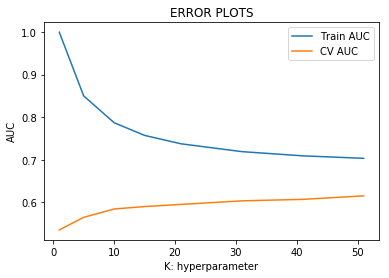

In [60]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier(algorithm= 'brute', n_jobs= -1)
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(tfidf_sent_vectors_train, y_train)

train_auc_b_tfw2v  = clf.cv_results_['mean_train_score']
cv_auc_b_tfw2v     = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc_b_tfw2v, label='Train AUC')
plt.plot(K, cv_auc_b_tfw2v, label='CV AUC')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [61]:
grid.best_estimator_

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=51, p=2,
           weights='uniform')

In [62]:
best_k_b_tfw2v = 51

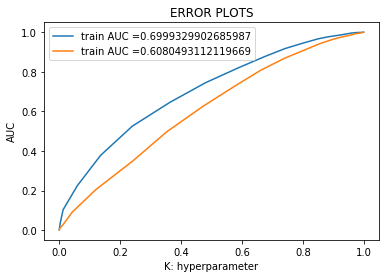

Train confusion matrix
[[    1  2163]
 [    0 11591]]
Test confusion matrix
[[   0 1307]
 [   1 7114]]


In [63]:
neigh = KNeighborsClassifier(n_neighbors = best_k_b_tfw2v, algorithm='brute', n_jobs=-1)
neigh.fit(tfidf_sent_vectors_train, y_train)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_b_tfw2v, train_tpr_b_tfw2v, thresholds_b_tfw2v = roc_curve(y_train, neigh.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr_b_tfw2v, test_tpr_b_tfw2v, thresholds_b_tfw2v   = roc_curve(y_test, neigh.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr_b_tfw2v, train_tpr_b_tfw2v, label="train AUC ="+str(auc(train_fpr_b_tfw2v, train_tpr_b_tfw2v)))
plt.plot(test_fpr_b_tfw2v, test_tpr_b_tfw2v, label="train AUC ="+str(auc(test_fpr_b_tfw2v, test_tpr_b_tfw2v)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test)))

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

#### First we need to convert sparse vectors formed by bow to dense metrices

converting sparse metrice to dense metrices using todense() function

In [102]:
# converting sparse metrices to dense metrices using todense() 
x_train_bow_dense = x_train_bow.todense()
x_cv_bow_dense    = x_cv_bow.todense()
x_test_bow_dense  = x_test_bow.todense()

print("After converting these sparse metrices to dense metrices")

print(x_train_bow_dense.shape, y_train.shape)
print(x_cv_bow_dense.shape,          y_cv.shape)
print(x_test_bow_dense.shape,  y_test.shape)

print("="*50)

print("the type of count vectorizer ",type(x_train_bow_dense))
print("the type of count vectorizer ",type(x_cv_bow_dense))
print("the type of count vectorizer ",type(x_test_bow_dense))

After converting these sparse metrices to dense metrices
(9482, 3442) (9482,)
(4065, 3442) (4065,)
(5807, 3442) (5807,)
the type of count vectorizer  <class 'numpy.matrix'>
the type of count vectorizer  <class 'numpy.matrix'>
the type of count vectorizer  <class 'numpy.matrix'>


Hyperparameter tuning using Grid Search, which seems to work better as compared to for loop we use

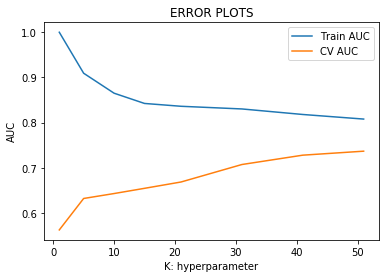

In [105]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier(algorithm= 'kd_tree', n_jobs= -1)
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(x_train_bow_dense, y_train)

train_auc_bow_kd      = clf.cv_results_['mean_train_score']
cv_auc_bow_kd         = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc_bow_kd, label='Train AUC')
plt.plot(K, cv_auc_bow_kd, label='CV AUC')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

Hyperparameter tuning using simple for loops which consumes alot of memory as well as takes alot of time to compute the results

In [106]:
clf.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=51, p=2,
           weights='uniform')

In [107]:
best_k_kd_bow =51

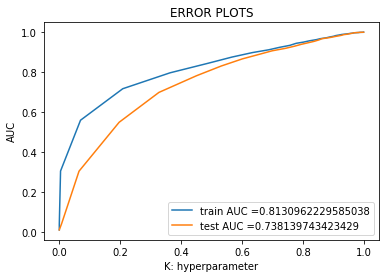

Train confusion matrix
[[  63 1385]
 [  47 7987]]
Test confusion matrix
[[  36  905]
 [  26 4840]]


In [108]:
neigh = KNeighborsClassifier(n_neighbors = best_k_kd_bow, algorithm='kd_tree')
neigh.fit(x_train_bow_dense, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr_bow_kd, train_tpr_bow_kd, thresholds_bow_kd = roc_curve(y_train, neigh.predict_proba(x_train_bow_dense)[:,1])
test_fpr_bow_kd, test_tpr_bow_kd, thresholds_bow_kd = roc_curve(y_test, neigh.predict_proba(x_test_bow_dense)[:,1])

plt.plot(train_fpr_bow_kd, train_tpr_bow_kd, label="train AUC ="+str(auc(train_fpr_bow_kd, train_tpr_bow_kd)))
plt.plot(test_fpr_bow_kd, test_tpr_bow_kd, label="test AUC ="+str(auc(test_fpr_bow_kd, test_tpr_bow_kd)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train_bow_dense)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test_bow_dense)))

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

converting sparse metrices from tfidf featurization to dense metrices before applying kd-tree knn

In [109]:
# converting sparse metrices to dense metrices using todense() 
x_train_tf_dense = x_train_tf.todense()
x_cv_tf_dense    = x_cv_tf.todense()
x_test_tf_dense  = x_test_tf.todense()

print("After converting these sparse metrices to dense metrices")

print(x_train_tf_dense.shape, y_train.shape)
print(x_cv_tf_dense.shape,    y_cv.shape)
print(x_test_bow_dense.shape, y_test.shape)

print("="*50)

print("the type of count vectorizer ",type(x_train_tf_dense))
print("the type of count vectorizer ",type(x_cv_tf_dense))
print("the type of count vectorizer ",type(x_test_tf_dense))

After converting these sparse metrices to dense metrices
(9482, 3442) (9482,)
(4065, 3442) (4065,)
(5807, 3442) (5807,)
the type of count vectorizer  <class 'numpy.matrix'>
the type of count vectorizer  <class 'numpy.matrix'>
the type of count vectorizer  <class 'numpy.matrix'>


Hyperparameter tuning using Grid Search

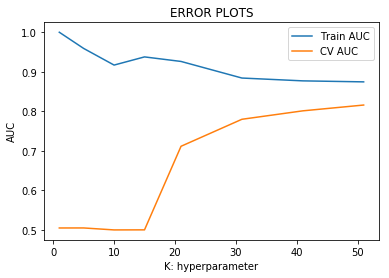

In [111]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier(algorithm= "kd_tree", n_jobs= -1)
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(x_train_tf_dense, y_train)

train_auc_tfidf_kd      = clf.cv_results_['mean_train_score']
cv_auc_tfidf_kd         = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc_tfidf_kd, label='Train AUC')
plt.plot(K, cv_auc_tfidf_kd, label='CV AUC')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [112]:
clf.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=51, p=2,
           weights='uniform')

In [113]:
best_k_kd_tf = 51  # from grid search we take this value of K

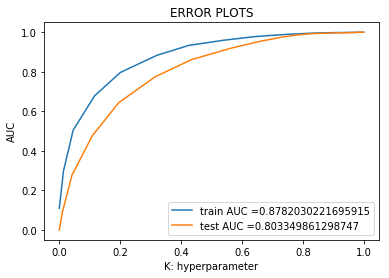

Train confusion matrix
[[   0 1448]
 [   0 8034]]
Test confusion matrix
[[   0  941]
 [   0 4866]]


In [114]:
neigh = KNeighborsClassifier(n_neighbors = best_k_kd_tf, algorithm= 'kd_tree', n_jobs= -1)
neigh.fit(x_train_tf_dense, y_train)

train_fpr_tfidf_kd, train_tpr_tfidf_kd, thresholds_tfidf_kd = roc_curve(y_train, neigh.predict_proba(x_train_tf_dense)[:,1])
test_fpr_tfidf_kd, test_tpr_tfidf_kd, thresholds_tfidf_kd = roc_curve(y_test, neigh.predict_proba(x_test_tf_dense)[:,1])

plt.plot(train_fpr_tfidf_kd, train_tpr_tfidf_kd, label="train AUC ="+str(auc(train_fpr_tfidf_kd, train_tpr_tfidf_kd)))
plt.plot(test_fpr_tfidf_kd, test_tpr_tfidf_kd, label="test AUC ="+str(auc(test_fpr_tfidf_kd, test_tpr_tfidf_kd)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train_tf_dense)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test_tf_dense)))

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [3]:
# Please write all the code with proper documentation

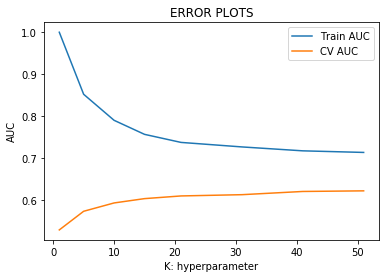

In [115]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier(algorithm= 'kd_tree', n_jobs= -1)
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(sent_vectors_train, y_train)

train_auc_kd_aw2v  = clf.cv_results_['mean_train_score']
cv_auc_kd_aw2v     = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc_kd_aw2v, label='Train AUC')
plt.plot(K, cv_auc_kd_aw2v, label='CV AUC')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [116]:
clf.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=51, p=2,
           weights='uniform')

In [117]:
best_k_kd_aw2v = 51

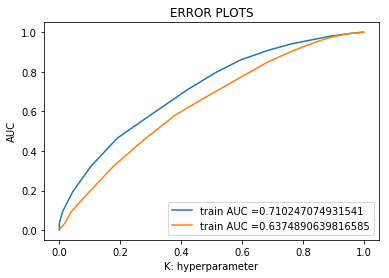

Train confusion matrix
[[   1 1447]
 [   0 8034]]
Test confusion matrix
[[   1  940]
 [   0 4866]]


In [118]:
neigh = KNeighborsClassifier(n_neighbors = best_k_kd_aw2v, algorithm='kd_tree', n_jobs=-1)
neigh.fit(sent_vectors_train, y_train)

train_fpr_kd_aw2v, train_tpr_kd_aw2v, thresholds_kd_aw2v = roc_curve(y_train, neigh.predict_proba(sent_vectors_train)[:,1])
test_fpr_kd_aw2v, test_tpr_kd_aw2v, thresholds_kd_aw2v   = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_kd_aw2v, train_tpr_kd_aw2v, label="train AUC ="+str(auc(train_fpr_kd_aw2v, train_tpr_kd_aw2v)))
plt.plot(test_fpr_kd_aw2v, test_tpr_kd_aw2v, label="train AUC ="+str(auc(test_fpr_kd_aw2v, test_tpr_kd_aw2v)))

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(sent_vectors_test)))

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [3]:
# Please write all the code with proper documentation

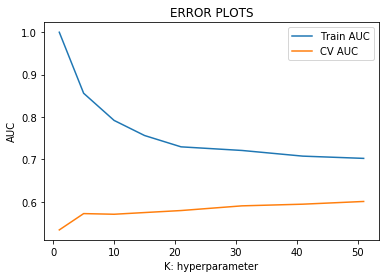

In [119]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

neigh = KNeighborsClassifier(algorithm= 'kd_tree', n_jobs= -1)
parameters = {'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51]}
clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc')
clf.fit(tfidf_sent_vectors_train, y_train)

train_auc_kd_tfw2v  = clf.cv_results_['mean_train_score']
cv_auc_kd_tfw2v     = clf.cv_results_['mean_test_score'] 

plt.plot(K, train_auc_kd_tfw2v, label='Train AUC')
plt.plot(K, cv_auc_kd_tfw2v, label='CV AUC')

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [120]:
clf.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=51, p=2,
           weights='uniform')

In [121]:
best_k_kd_tfw2v = 51

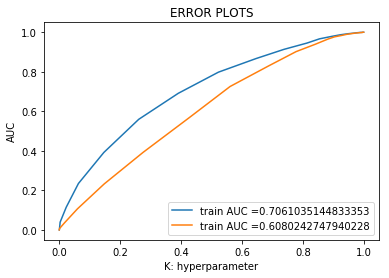

Train confusion matrix
[[   0 1448]
 [   0 8034]]
Test confusion matrix
[[   1  940]
 [   1 4865]]


In [122]:
neigh = KNeighborsClassifier(n_neighbors = best_k_kd_tfw2v, algorithm='kd_tree', n_jobs=-1)
neigh.fit(tfidf_sent_vectors_train, y_train)

train_fpr_kd_tfw2v, train_tpr_kd_tfw2v, thresholds_kd_tfw2v = roc_curve(y_train, neigh.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr_kd_tfw2v, test_tpr_kd_tfw2v, thresholds_kd_tfw2v   = roc_curve(y_test, neigh.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr_kd_tfw2v, train_tpr_kd_tfw2v, label="train AUC ="+str(auc(train_fpr_kd_tfw2v, train_tpr_kd_tfw2v)))
plt.plot(test_fpr_kd_tfw2v, test_tpr_kd_tfw2v, label="train AUC ="+str(auc(test_fpr_kd_tfw2v, test_tpr_kd_tfw2v)))

plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(tfidf_sent_vectors_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(tfidf_sent_vectors_test)))

# [6] Conclusions

### Number of data points used for different implementations :

1. We loaded the data from a splite3 database file using sql command.
2. For Brute Force implementation of K-NN I used 30k points to speed up the things.
3. I experimented alot by using various number of data points ranging from 100k to 40k.
4. But it was completely freezing the system that's why, then I used only 30k points.
5. And for kd-tree implementation of K-NN I used 20k points.

### Data Cleaning and Preprocessing :

1. After loading the data we clean the data and preprocess it.
2. Remove duplicates and preprocessed text.
3. Which includes removing html tags, removing stop words etc.

### Applying Featurization :

1. Before we applied any featurization on the data.
2. We split the data in three parts train data, cross validation data and test data.
3. Then after splitting the data we applied various vectorization techniques.
4. We used BoW, TF-IDF, Average w2v and TF-IDF w2v.

Then we applied KNN using two different algorithms.
1. Brute Force Algorithm
2. KD-Tree Algorithm

After using AUC curves we observed that
> For Brute force implementation
* kNN with BoW and TF-IDF vectors perform better as compared to Average w2v and tf-idf w2v.
* And TF-IDF works even better when compared to BoW

> For KD-Tree implementation
* As expected kd-tree implementation works better as compared to brute force method for all featurization.
* And similarly like brute force algorithm, BoW and TF-IDF featurizations are performing better than Average w2v and tf-idf w2v.
* Plus on comparing BoW and TF-IDF, we again observed that TF-IDF is working better and is more capable to classify the data points than any other vectorizer.

In [142]:
names = ["KNN(Brute force) for BoW", "KNN(Brute force) for TF-IDF", "KNN(Brute force) for Average w2v", "KNN(Brute force) for TF-IDF w2v", "KNN(KD Tree) for BoW", "KNN(KD Tree) for TF-IDF", "KNN(KD Tree) for Average w2v", "KNN(KD Tree) for TF-IDF w2v"]
best_K = [ best_k_bow, best_k_tf, best_k_b_aw2v, best_k_b_tfw2v, best_k_kd_bow, best_k_kd_tf, best_k_kd_aw2v, best_k_kd_tfw2v]

number = [1, 2, 3, 4, 5, 6, 7, 8]

# Initializing prettytable 
# Adding columns 
ptable = PrettyTable()
ptable.add_column("S.NO.",number) 
ptable.add_column("MODEL",names)
ptable.add_column("Best K",best_K) 
#ptable.add_column("Train Accuracy",train_AUC)

#Printing the Table 
print(ptable)


+-------+----------------------------------+--------+
| S.NO. |              MODEL               | Best K |
+-------+----------------------------------+--------+
|   1   |     KNN(Brute force) for BoW     |   51   |
|   2   |   KNN(Brute force) for TF-IDF    |   51   |
|   3   | KNN(Brute force) for Average w2v |   51   |
|   4   | KNN(Brute force) for TF-IDF w2v  |   51   |
|   5   |       KNN(KD Tree) for BoW       |   51   |
|   6   |     KNN(KD Tree) for TF-IDF      |   51   |
|   7   |   KNN(KD Tree) for Average w2v   |   51   |
|   8   |   KNN(KD Tree) for TF-IDF w2v    |   51   |
+-------+----------------------------------+--------+
